# Detectron2 Tutorial
In this tutorial, we will use Detectron2 from Facebook AI Research (FAIR) to load our own dataset and train an object detection network.

## Register Training and Test Datasets
First, we will register our training and test datasets. Detectron2 has utilities to work with datasets formatted in the COCO format, which is commonly used.

NOTE: If you need to rerun this section, restart the Jupyter kernel first.

In [1]:
from detectron2.data.datasets import load_coco_json, register_coco_instances
from detectron2.data import MetadataCatalog

# TODO: Replace with small dataset that will be available in the repo

# Training dataset
training_dataset_name = "training_data"
training_json_file = "/home/sebastian/hsr_catkin_ws/src/csail_hsr/csail_hsr_vision/data/hsr_sim_training.json"
training_img_dir = "/home/sebastian/Workspace/coco-annotator/datasets/hsr_sim_training"
register_coco_instances(training_dataset_name, {}, training_json_file, training_img_dir)
training_dict = load_coco_json(training_json_file, training_img_dir,
                dataset_name=training_dataset_name)
training_metadata = MetadataCatalog.get(training_dataset_name)

# Test dataset
test_dataset_name = "test_data"
test_json_file = "/home/sebastian/hsr_catkin_ws/src/csail_hsr/csail_hsr_vision/data/hsr_sim_test.json"
test_img_dir = "/home/sebastian/Workspace/coco-annotator/datasets/hsr_sim_test"
register_coco_instances(test_dataset_name, {}, test_json_file, test_img_dir)
test_dict = load_coco_json(test_json_file, test_img_dir,
                dataset_name=test_dataset_name)
test_metadata = MetadataCatalog.get(test_dataset_name)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



## Display Images from the Training Dataset

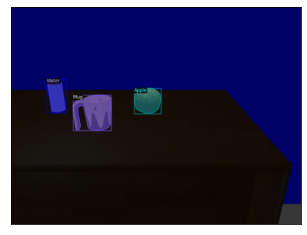

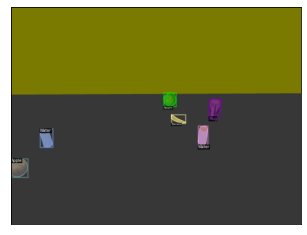

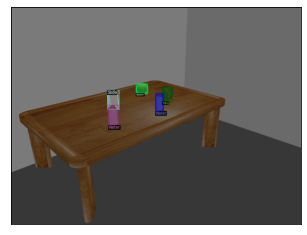

In [2]:
import cv2
import random
import matplotlib.pyplot as plt
%matplotlib inline
from detectron2.utils.visualizer import Visualizer

NUM_TRAINING_SAMPLES = 3
if NUM_TRAINING_SAMPLES > 0:
    samples = random.sample(training_dict, NUM_TRAINING_SAMPLES)
    for i, sample in enumerate(samples):
        img = cv2.imread(sample["file_name"])
        visualizer = Visualizer(img, metadata=training_metadata)
        visualizer = visualizer.draw_dataset_dict(sample)
        display_img = visualizer.get_image()[:, :, ::-1]
        plt.figure(i), plt.xticks([]), plt.yticks([])
        plt.imshow(display_img)

## Set Up Training Options

In [3]:
import os
from detectron2 import model_zoo
from detectron2.config import get_cfg

# Most importantly, let's set up a model type
# These are available in the Detectron2 model zoo
#
model_type = "maskrcnn"
if model_type == "maskrcnn":
    model_file = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
elif model_type == "retinanet":
    model_file = "COCO-Detection/retinanet_R_50_FPN_3x.yaml"
    
# Create a configuration and set up the model and datasets
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model_file))
cfg.DATASETS.TRAIN = (training_dataset_name,)
cfg.DATASETS.TEST = (test_dataset_name,)
cfg.OUTPUT_DIR = f"{model_type}_training_output"
cfg.DATALOADER.NUM_WORKERS = 4
if model_type == "maskrcnn":
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(training_metadata.thing_classes)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
if model_type == "retinanet":
    cfg.MODEL.RETINANET.NUM_CLASSES = len(training_metadata.thing_classes)
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.05
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_file)  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # (default: 512)

# Learning rate options
cfg.SOLVER.BASE_LR = 1e-3           # Base learning rate
cfg.SOLVER.GAMMA = 0.5              # Learning rate decay
cfg.SOLVER.STEPS = (250, 500, 750)  # Iterations at which to decay learning rate
cfg.SOLVER.MAX_ITER = 1000          # Maximum number of iterations
cfg.SOLVER.WARMUP_ITERS = 100       # Warmup iterations to linearly ramp learning rate from zero
cfg.SOLVER.IMS_PER_BATCH = 1        # Lower to reduce memory usage (1 is the lowest)

## Train the Model
While training, you can view progress on Tensorboard. For example, if you are training a Mask R-CNN model:

* In a Terminal, run `tensorboard --logdir=maskrcnn_training_output`
* In your favorite browser and go to `localhost:6006`

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from detectron2.data import DatasetMapper, transforms, build_detection_train_loader
from detectron2.engine import DefaultTrainer, SimpleTrainer
from detectron2.engine.hooks import PeriodicWriter

# Custom Trainer class to include custom data augmentations
class Trainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        # Set up data augmentation
        augs = [transforms.ResizeShortestEdge(
                    [640, 672, 704, 736, 768, 800],
                     max_size=1333, sample_style="choice"),
                transforms.RandomBrightness(0.8, 1.2),
                transforms.RandomSaturation(0.8, 1.2),
                transforms.RandomFlip(prob=0.5)]
        data_loader = build_detection_train_loader(cfg,
            mapper=DatasetMapper(cfg, is_train=True, 
                                 augmentations=augs))
        return data_loader
    

# Create an output folder and delete any old files
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
for fname in os.listdir(cfg.OUTPUT_DIR):
    if "tfevents" in fname:
        os.remove(os.path.join(cfg.OUTPUT_DIR, fname))
        
# Create a Trainer using the data augmentations defined above and train the network
# To avoid creating a custom trainer class, you can use 
#  `trainer = SimpleTrainer(cfg)` : A no-frills training pipeline with nothing added  
#  `trainer = DefaultTrainer(cfg)` : The default training pipeline with some data augmentation and hooks
trainer = Trainer(cfg)

# Hack to reduce the printing frequency, which defaults to every 20 iterations..
# There is a cleaner way to do this using `trainer.build_hooks()` but it requires much more effort.
for hook in trainer._hooks:
    if isinstance(hook, PeriodicWriter):
        hook._period = 50
        
# Finally, train the network
trainer.resume_or_load(resume=False)
trainer.train()

[11/22 09:59:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[11/22 09:59:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=[640, 672, 704, 736, 768, 800], max_size=1333, sample_style='choice'), RandomBrightness(intensity_min=0.8, intensity_max=1.2), RandomSaturation(intensity_min=0.8, intensity_max=1.2), RandomFlip(prob=0.5)]
WARNING [11/22 09:59:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/22 09:59:36 d2.data.datasets.coco]: Loaded 57 images in COCO format from /home/sebastian/hsr_catkin_ws/src/csail_hsr/csail_hsr_vision/data/hsr_sim_training.json
[11/22 09:59:36 d2.data.build]: Removed 0 images with no usable annotations. 57 images left.
[11/22 09:59:36 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   Apple    | 34 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (6, 256, 1, 1) 

[11/22 09:59:36 d2.engine.train_loop]: Starting training from iteration 0
[11/22 10:00:05 d2.utils.events]:  eta: 0:08:54  iter: 49  total_loss: 1.943  loss_cls: 0.6208  loss_box_reg: 0.9068  loss_mask: 0.4006  loss_rpn_cls: 0.001222  loss_rpn_loc: 0.00995  time: 0.5657  data_time: 0.0018  lr: 0.00049051  max_mem: 1491M
[11/22 10:00:33 d2.utils.events]:  eta: 0:08:28  iter: 99  total_loss: 0.8035  loss_cls: 0.196  loss_box_reg: 0.4643  loss_mask: 0.09264  loss_rpn_cls: 0.0001535  loss_rpn_loc: 0.01117  time: 0.5685  data_time: 0.0019  lr: 0.00099001  max_mem: 1491M
[11/22 10:01:03 d2.utils.events]:  eta: 0:08:01  iter: 149  total_loss: 0.4794  loss_cls: 0.1325  loss_box_reg: 0.2472  loss_mask: 0.06703  loss_rpn_cls: 0.000165  loss_rpn_loc: 0.01931  time: 0.5748  data_time: 0.0017  lr: 0.001  max_mem: 1491M
[11/22 10:01:32 d2.utils.events]:  eta: 0:07:33  iter: 199  total_loss: 0.3741  loss_cls: 0.06728  loss_box_reg: 0.2186  loss_mask: 0.0747  loss_rpn_cls: 0.000318  loss_rpn_loc: 0.01

## Evaluate Trained Model On Test Set

In [7]:
from detectron2.evaluation import COCOEvaluator

# Load weights from the most recent training run
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# Run the official Detectron2 test evaluator, which returns useful metrics
evaluator = COCOEvaluator(test_dataset_name, cfg, False, 
            output_dir=os.path.join(f"{model_type}_test_output"))
trainer.test(cfg, trainer.model, evaluators=evaluator)

WARNING [11/22 10:11:06 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
WARNING [11/22 10:11:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/22 10:11:06 d2.data.datasets.coco]: Loaded 24 images in COCO format from /home/sebastian/hsr_catkin_ws/src/csail_hsr/csail_hsr_vision/data/hsr_sim_test.json
[11/22 10:11:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/22 10:11:06 d2.data.common]: Serializing 24 elements to byte tensors and concatenating them all ...
[11/22 10:11:06 d2.data.common]: Serialized dataset takes 0.04 MiB
[11/22 10:11:06 d2.evaluation.evaluator]: Start inference on 24 images
[11/22 10:11:09 d2.evaluation.evaluator]: Inference done 11/24. 0.2550 s / img. ETA=0:00:03
[11/22 10:11:13 d2.evaluation.e

OrderedDict([('bbox',
              {'AP': 75.88697533693598,
               'AP50': 89.35744810744809,
               'AP75': 86.35909284261207,
               'APs': 67.00416386105546,
               'APm': 82.11841543128672,
               'APl': 100.0,
               'AP-Apple': 85.26544082979729,
               'AP-Banana': 82.01025459688826,
               'AP-Cell Phone': 82.51783937792277,
               'AP-Soda': 89.38763789795847,
               'AP-Water': 57.552297537446066,
               'AP-Mug': 58.588381781603026}),
             ('segm',
              {'AP': 78.431541542858,
               'AP50': 89.34448252517558,
               'AP75': 87.70197504700302,
               'APs': 68.71669547907172,
               'APm': 86.09180269530712,
               'APl': 100.0,
               'AP-Apple': 92.94200848656294,
               'AP-Banana': 81.60891089108911,
               'AP-Cell Phone': 83.65440537861836,
               'AP-Soda': 92.9401662763718,
               'A

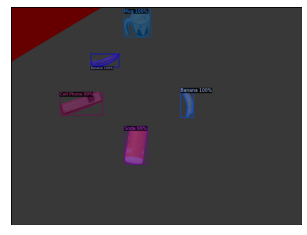

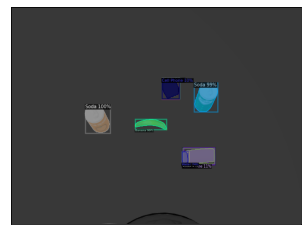

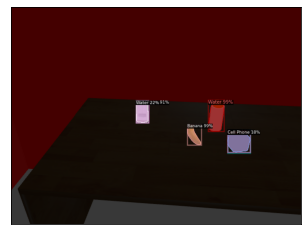

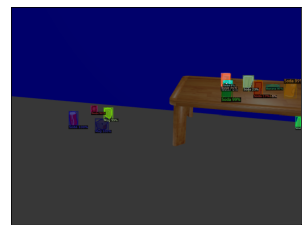

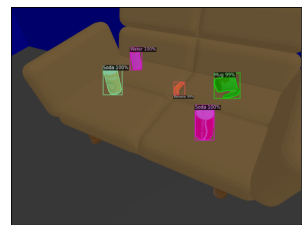

In [9]:
del(trainer) # To free up memory just in case

# Create a predictor using the trained model
from detectron2.engine import DefaultPredictor
predictor = DefaultPredictor(cfg)

# Show some qualitative results by predicting on test set images
NUM_TEST_SAMPLES = 5
samples = random.sample(test_dict, NUM_TEST_SAMPLES)
for i, sample in enumerate(samples):
    img = cv2.imread(sample["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img, metadata=test_metadata)
    visualizer = visualizer.draw_instance_predictions(
        outputs["instances"].to("cpu"))
    display_img = visualizer.get_image()[:, :, ::-1]
    plt.figure(i), plt.xticks([]), plt.yticks([])
    plt.imshow(display_img)